# Analiza i projektiranje računalom - 4. domaća zadaća

U okviru ove zadaće treba izraditi programsku implementaciju genetskog (evolucijskog) algoritma koja će pronalaziti minimum zadane višedimenzijske funkcije. Potrebno je omogućiti da se bez prevođenja programa može definirati:

- prikaz rješenja koji će algoritam koristiti
- veličina populacije
- vjerojatnost mutacije (i križanja, ako algoritam koristi taj parametar)
- broj evaluacija funkcije cilja kao kriterij zaustavljanja (ostali su proizvoljni)

Programsko ostvarenje mora podržavati *binarni prikaz rješenja* te *prikaz brojem s pomičnom točkom* (način prikaza je parametar algoritma). Oba prikaza trebaju definirati donju i gornju granicu domene (eksplicitna ograničenja) i broj varijabli. Binarni prikaz dodatno treba definirati željenu preciznost (npr. kao broj decimala ili najveći dopušteni razmak susjednih rješenja). Za svaki od prikaza potrebno je definirati barem do *dva operatora križanja* i barem po *jedan operator mutacije*. Svi operatori moraju podržavati definirana eksplicitna ograničenja.

**Ispis algoritma** je proizvoljan, no mora omogućiti uvid u ove podatke:

- broj evaluacija
- trenutna najbolja jedinka
- vrijednost funkcije cilja najbolje jedinke

Preporučena (ali nipošto i jedina moguća) inačica GA je 3-turnirski eliminacijski odabir:

```pseudocode
stvori populaciju
evaluiraj populaciju    //svaka jedinka ima pridruženu dobrotu

ponavljaj
    odaberi slučajno 3 jedinke
    izbaci najlošiju od 3 odabrane iz populacije
    
    nova jedinka = križanje(preostale dvije)
    obavi mutaciju na novoj jedinki uz neku vjerojatnost
    
    evaluiraj novu jedinku
    dodaj novu jedinku u populaciju
dok nije zadovoljen uvjet zaustavljanja
```

---

## Funkcije cilja

### Funkcija 1 - Rosenbrockova "banana" funkcija

$$
\begin{equation}
    f_1 \left( \vec{x} \right) = 100 \left( x_1 - {x_0}^2 \right)^2 + \left( 1 - x_0 \right)^2
\end{equation}
$$

$$
\begin{equation}
    \vec{x_{min}} =
    \begin{bmatrix}
        1 & 1
    \end{bmatrix}
\end{equation}
$$

$$
\begin{equation}
    f_1 \left( \vec{x_{min}} \right) = 0
\end{equation}
$$

### Funkcija 2

$$
\begin{equation}
    f_3 \left( \vec{x} \right) = \sum_i{\left( x_i - i \right)^2}
\end{equation}
$$

$$
\begin{equation}
    \vec{x_{min}} =
    \begin{bmatrix}
        1 & 2 & 3 & \dots & n
    \end{bmatrix}
\end{equation}
$$

$$
\begin{equation}
    f_3 \left( \vec{x_{min}} \right) = 0
\end{equation}
$$

### Funkcija 3 - Schafferova F6 funkcija

$$
\begin{equation}
    f_6 \left( \vec{x} \right) = 0.5 + \frac{%
        \sin^2 \left( \sqrt{\sum{{x_i}^2}} \right) - 0.5
    }{%
        \left( 1 + 0.001 \sum{{x_i}^2}\right)^2
    }
\end{equation}
$$

$$
\begin{equation}
    \vec{x_{min}} = \vec{0}
\end{equation}
$$

$$
\begin{equation}
    f_6 \left( \vec{x_{min}} \right) = 0
\end{equation}
$$

### Funkcija 4 - Schafferova F7 funkcija

$$
\begin{equation}
    f_7 \left( \vec{x} \right) = \left( \sum{{x_i}^2} \right)^{\frac{1}{4}} \cdot
    \left(
        1 + \sin^2 \left(
            50 \left(
                \sum{x_i}^2
            \right)^{\frac{1}{10}}
        \right)
    \right)
\end{equation}
$$

$$
\begin{equation}
    \vec{x_0} = 
    \begin{bmatrix}
        0 & 0
    \end{bmatrix}
\end{equation}
$$

$$
\begin{equation}
    f_4 \left( \vec{x_{min}} \right) = 0
\end{equation}
$$

## Priprema za izvođenje

In [1]:
import os

CD_KEY = "--HW04_IN_ROOT"

In [2]:
if (
    CD_KEY not in os.environ
    or os.environ[CD_KEY] is None
    or len(os.environ[CD_KEY]) == 0
    or os.environ[CD_KEY] == "false"
):
    %cd ..
else:
    print(os.getcwd())
    
os.environ[CD_KEY] = "true"

/mnt/data/projekti/faks/AIPR/dz/dz-04


## Učitavanje paketa

In [3]:
import copy
import os
import pickle
import sys
import warnings

import array_to_latex as a2l
from IPython.display import display, Markdown
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from src.evolution.crossover import *
from src.evolution.encoding import *
from src.evolution.function import Function
from src.evolution.mutation import *
from src.evolution.selection import *
from src.evolutionary_tournament import EvolutionaryTournament
from src.ga import simple_ga
from src.utils import *

In [4]:
np.set_printoptions(precision=2, suppress=True)
np.random.seed(21051208)
warnings.filterwarnings('ignore')

## Definicija pomoćnih funkcija

In [5]:
def array_to_latex(array):
    return a2l.to_ltx(
        array,
        frmt="{:g}",
        arraytype="bmatrix",
        print_out=False
    )

## Definicija funkcija i početnih točaka

In [6]:
def f1(x: np.ndarray):
    return 100 * np.square(np.square(x[1] - x[0])) + np.square(1. - x[0])

In [7]:
def get_f3(length: int):
    _subtractor = np.array(range(1, length + 1))
    
    def _f(x: np.ndarray):
        return np.sum(np.square(x - _subtractor))
    
    return _f

In [8]:
def f6(x: np.ndarray):
    sum_of_squares = np.sum(np.square(x))
    
    return (
        0.5
        + (
            (np.square(np.sin(np.sqrt(sum_of_squares))) - 0.5) /
            np.square(1 + 0.001 * sum_of_squares)
        )
    )

In [9]:
def f7(x: np.ndarray):
    sum_of_squares = np.sum(np.square(x))
    
    return (
        np.power(sum_of_squares, 0.25) * (
            1.0 + np.square(
                np.sin(
                    50 * np.power(sum_of_squares, 0.1)
                )
            )
        )
    )

## Zadatci

### Zadatak 1

Isprobajte vašu implementaciju GA nad svim funkcijama uz granice $\left[ -50, 150 \right]$ za sve varijable te za oba prikaza rješenja (binarni, s pomičnom točkom).

In [10]:
t1_interval = (-50, 150)

Za binarni prikaz zadajte preciznost od barem tri decimalna mjesta.

In [11]:
t1_n_decimals = 3
t1_dim = get_binary_dim_for_interval_and_decimals(
    interval=t1_interval, n_decimals=t1_n_decimals
)
display(
    Markdown(
        f"Za interval $[{t1_interval[0]}, {t1_interval[1]}]$ "
        f"trebat ćemo ${t1_dim}$ binarnih znamenaka da bi "
        f"imali preciznost na ${t1_n_decimals}$ decimale."
    )
)

Za interval $[-50, 150]$ trebat ćemo $18$ binarnih znamenaka da bi imali preciznost na $3$ decimale.

In [12]:
t1_be = BinaryEncoder(
    dim=t1_dim, interval=t1_interval
)
t1_bd = BinaryDecoder(
    dim=t1_dim, interval=t1_interval
)

Za funkciju $f_3$ odaberite barem $5$ varijabli, a za $f_6$ i $f_7$ dvije varijable.

In [13]:
t1_f3_n = 5
t1_f6_n = 2
t1_f7_n = 2

In [14]:
t1_f3 = get_f3(t1_f3_n)
t1_f6 = copy.deepcopy(f6)
t1_f7 = copy.deepcopy(f7)

In [15]:
t1_f3_binary = Function(lambda x: -t1_f3(t1_bd(x)))
t1_f3_float = Function(lambda x: -t1_f3(x))

In [16]:
t1_f6_binary = Function(lambda x: -t1_f6(t1_bd(x)))
t1_f6_float = Function(lambda x: -t1_f6(x))

In [17]:
t1_f7_binary = Function(lambda x: -t1_f7(t1_bd(x)))
t1_f7_float = Function(lambda x: -t1_f7(x))

Za sve funkcije možete smatrati da je rješenje pronađeno ako je krajnja vrijednost funkcije cilja manja od $10^{-6}$. Za neke funkcije algoritam će biti potrebno pokrenuti nekoliko puta.

**Odgovor**

In [18]:
t1_max_retries = 3
t1_max_iterations = 10000
t1_capacity = 20
t1_elitism = 1
t1_epsilon = 1e-6

In [19]:
t1_mp_schedule = lambda x: 0.05 * (np.sin(x/1000) + 1)

In [20]:
t1_et_binary = EvolutionaryTournament(
    selection=TournamentSelection(),
    crossover=ANDCrossover(),
    mutation=StochasticCorruptionMutation()
)
t1_et_float = EvolutionaryTournament(
    selection=TournamentSelection(),
    crossover=ChooseOneCrossover(interval=t1_interval),
    mutation=GaussianMutation()
)

#### Funkcija $f_3$ - binarno

In [21]:
t1_f3_binary_results = simple_ga(
    wellness_function=t1_f3_binary,
    specimen_length=t1_f3_n,
    interval=t1_interval,
    evolutionary_tournament=t1_et_binary,
    max_retries=t1_max_retries,
    max_iterations=t1_max_iterations,
    population_capacity=t1_capacity,
    elitism=t1_elitism,
    epsilon=t1_epsilon,
    mutation_scheduler=t1_mp_schedule,
    encoding_function=t1_be,
    decoding_function=t1_bd,
)

[9771] [0.88 1.95 3.13 4.   5.08] (-0.04): 100%|██████████| 10000/10000 [00:05<00:00, 1952.55it/s]          


In [22]:
t1_f3_binary_best = sorted(t1_f3_binary_results, key=lambda x: x.wellness)[-1]

display(
    Markdown(
        f"Pronađen je minimum vrijednosti ${-t1_f3_binary_best.wellness:.06f}$ "
        f"u točki {array_to_latex(t1_bd(t1_f3_binary_best.element))}"
    )
)

Pronađen je minimum vrijednosti $0.031142$ u točki \begin{bmatrix}
  0.8791 &  1.95332 &  2.9421 &  4.00411 &  4.89523
\end{bmatrix}

#### Funkcija $f_6$ - binarno

In [23]:
t1_f6_binary_results = simple_ga(
    wellness_function=t1_f6_binary,
    specimen_length=t1_f6_n,
    interval=t1_interval,
    evolutionary_tournament=t1_et_binary,
    max_retries=t1_max_retries,
    max_iterations=t1_max_iterations,
    population_capacity=t1_capacity,
    elitism=t1_elitism,
    epsilon=t1_epsilon,
    mutation_scheduler=t1_mp_schedule,
    encoding_function=t1_be,
    decoding_function=t1_bd,
)

[759] [0. 0.] (-0.00):   8%|▊         | 759/10000 [00:00<00:04, 2040.06it/s]        


In [24]:
t1_f6_binary_best = sorted(t1_f6_binary_results, key=lambda x: x.wellness)[-1]

display(
    Markdown(
        f"Pronađen je minimum vrijednosti ${-t1_f6_binary_best.wellness:.06f}$ "
        f"u točki {array_to_latex(t1_bd(t1_f6_binary_best.element))}"
    )
)

Pronađen je minimum vrijednosti $0.000000$ u točki \begin{bmatrix}
  0.000190736 &  0.000190736
\end{bmatrix}

#### Funkcija $f_7$ - binarno

In [25]:
t1_f7_binary_results = simple_ga(
    wellness_function=t1_f7_binary,
    specimen_length=t1_f7_n,
    interval=t1_interval,
    evolutionary_tournament=t1_et_binary,
    max_retries=t1_max_retries,
    max_iterations=t1_max_iterations,
    population_capacity=t1_capacity,
    elitism=t1_elitism,
    epsilon=t1_epsilon,
    mutation_scheduler=t1_mp_schedule,
    encoding_function=t1_be,
    decoding_function=t1_bd,
)

[352] [0. 0.] (-0.02): 100%|██████████| 10000/10000 [00:04<00:00, 2090.99it/s]


In [26]:
t1_f7_binary_best = sorted(t1_f7_binary_results, key=lambda x: x.wellness)[-1]

display(
    Markdown(
        f"Pronađen je minimum vrijednosti ${-t1_f7_binary_best.wellness:.06f}$ "
        f"u točki {array_to_latex(t1_bd(t1_f7_binary_best.element))}"
    )
)

Pronađen je minimum vrijednosti $0.017346$ u točki \begin{bmatrix}
  0.000190736 &  0.000190736
\end{bmatrix}

---

In [27]:
t1_mp_float_schedule = t1_mp_schedule = lambda x: 0.5 * (np.sin(x/1000) + 1)

#### Funkcija $f_3$ - pomična točka

In [28]:
t1_f3_float_results = simple_ga(
    wellness_function=t1_f3_float,
    specimen_length=t1_f3_n,
    interval=t1_interval,
    evolutionary_tournament=t1_et_float,
    max_retries=t1_max_retries,
    max_iterations=t1_max_iterations,
    population_capacity=t1_capacity,
    elitism=t1_elitism,
    epsilon=t1_epsilon,
    mutation_scheduler=t1_mp_schedule,
)

[6424] [1.   2.01 2.99 4.03 5.  ] (-0.00): 100%|██████████| 10000/10000 [00:04<00:00, 2474.63it/s]    


In [29]:
t1_f3_float_best = sorted(t1_f3_float_results, key=lambda x: x.wellness)[-1]

display(
    Markdown(
        f"Pronađen je minimum vrijednosti ${-t1_f3_float_best.wellness:.06f}$ "
        f"u točki {array_to_latex(t1_f3_float_best.element)}"
    )
)

Pronađen je minimum vrijednosti $0.000345$ u točki \begin{bmatrix}
  1.00362 &  1.99229 &  3.016 &  4.00241 &  5.00327
\end{bmatrix}

#### Funkcija $f_6$ - pomična točka

In [30]:
t1_f6_float_results = simple_ga(
    wellness_function=t1_f6_float,
    specimen_length=t1_f6_n,
    interval=t1_interval,
    evolutionary_tournament=t1_et_float,
    max_retries=t1_max_retries,
    max_iterations=t1_max_iterations,
    population_capacity=t1_capacity,
    elitism=t1_elitism,
    epsilon=t1_epsilon,
    mutation_scheduler=t1_mp_schedule,
)

[3384] [-1.77 -2.59] (-0.01): 100%|██████████| 10000/10000 [00:03<00:00, 2608.80it/s]


In [31]:
t1_f6_float_best = sorted(t1_f6_float_results, key=lambda x: x.wellness)[-1]

display(
    Markdown(
        f"Pronađen je minimum vrijednosti ${-t1_f6_float_best.wellness:.06f}$ "
        f"u točki {array_to_latex(t1_f6_float_best.element)}"
    )
)

Pronađen je minimum vrijednosti $0.000005$ u točki \begin{bmatrix}
  0.00213936 &  0.000910992
\end{bmatrix}

#### Funkcija $f_7$ - pomična točka

In [32]:
t1_f7_float_results = simple_ga(
    wellness_function=t1_f7_float,
    specimen_length=t1_f7_n,
    interval=t1_interval,
    evolutionary_tournament=t1_et_float,
    max_retries=t1_max_retries,
    max_iterations=t1_max_iterations,
    population_capacity=t1_capacity,
    elitism=t1_elitism,
    epsilon=t1_epsilon,
    mutation_scheduler=t1_mp_schedule,
)

[9136] [ 0. -0.] (-0.06): 100%|██████████| 10000/10000 [00:03<00:00, 2701.24it/s]   


In [33]:
t1_f7_float_best = sorted(t1_f7_float_results, key=lambda x: x.wellness)[-1]

display(
    Markdown(
        f"Pronađen je minimum vrijednosti ${-t1_f7_float_best.wellness:.06f}$ "
        f"u točki {array_to_latex(t1_f7_float_best.element)}"
    )
)

Pronađen je minimum vrijednosti $0.056082$ u točki \begin{bmatrix}
  0.00151236 & -0.00240729
\end{bmatrix}

---

Koje zaključke možete donijeti o uspješnosti GA za pojedinu funkciju? Koje su se funkcije pokazale teškima i zašto? 

**Odgovor**:

Vidljivo je da su oba algoritma dobra za različite stvari. Na primjer, algoritam s binarnim zapisom ima problema s $f_3$, no zato iznimno brzo pronalazi minimume $f_6$ i $f_7$. S druge strane, algoritam sa zapisom s pomičnom točkom iznimno brzo nalazi rješenje za $f_3$, a ima problema s $f_6$ i $f_7$.

Moja hipoteza za takvo ponašanje su operatori križanja - operator kod binarnog zapisa koristi **logički i**, koji nije pogodan za $f_3$, ali je za ostale funkcije. S druge strane, u drugom algoritmu koristi se razmjena elemenata između roditelja, čime se vrlo lagano dolazi do rješenja $f_3$, ali ne i ostalih funkcija koje imaju puno lokalnih minimuma.

### Zadatak 2

Provedite GA na funkcijama $f_6$ i $f_7$ mijenjajući dimenzionalnost funkcije $\{1, 3, 6, 10\}$.

In [34]:
t2_length_range = (1, 3, 6, 10)

In [35]:
t2_interval = (-50, 150)

In [36]:
t2_n_decimals = 3
t2_dim = get_binary_dim_for_interval_and_decimals(
    interval=t2_interval, n_decimals=t2_n_decimals
)
display(
    Markdown(
        f"Za interval $[{t2_interval[0]}, {t2_interval[1]}]$ "
        f"trebat ćemo ${t2_dim}$ binarnih znamenaka da bi "
        f"imali preciznost na ${t2_n_decimals}$ decimale."
    )
)

Za interval $[-50, 150]$ trebat ćemo $18$ binarnih znamenaka da bi imali preciznost na $3$ decimale.

In [37]:
t2_be = BinaryEncoder(
    dim=t2_dim, interval=t2_interval
)
t2_bd = BinaryDecoder(
    dim=t2_dim, interval=t2_interval
)

In [38]:
t2_f6 = copy.deepcopy(f6)
t2_f7 = copy.deepcopy(f7)

In [39]:
t2_f6_binary = Function(lambda x: -t2_f6(t2_bd(x)))
t2_f7_binary = Function(lambda x: -t2_f7(t2_bd(x)))

In [40]:
t2_max_retries = 3
t2_max_iterations = 10000
t2_capacity = 20
t2_elitism = 1
t2_epsilon = 1e-6

In [41]:
t2_mp_schedule = lambda x: 0.05 * (np.sin(x/1000) + 1)

In [42]:
t2_et_binary = EvolutionaryTournament(
    selection=TournamentSelection(),
    crossover=ANDCrossover(),
    mutation=StochasticCorruptionMutation()
)

In [43]:
for length in t2_length_range:
    t2_results = simple_ga(
    wellness_function=t2_f6_binary,
    specimen_length=length,
    interval=t2_interval,
    evolutionary_tournament=t2_et_binary,
    max_retries=t2_max_retries,
    max_iterations=t2_max_iterations,
    population_capacity=t2_capacity,
    elitism=t2_elitism,
    epsilon=t2_epsilon,
    mutation_scheduler=t2_mp_schedule,
    encoding_function=t2_be,
    decoding_function=t2_bd,
    )
    
    _best = sorted(t2_results, key= lambda x: x.wellness)[-1]
    
    print(f"Za duljinu {length} pronađen je minimum ({-_best.wellness:.06f}).\n\n")

[61] [0.] (-0.00):   1%|          | 61/10000 [00:00<00:07, 1398.38it/s]
Za duljinu 1 pronađen je minimum (0.000000).


[340] [0. 0. 0.] (-0.00):   3%|▎         | 340/10000 [00:00<00:05, 1856.34it/s]      
Za duljinu 3 pronađen je minimum (0.000001).


[5661] [-8.59  0.    0.   -9.37  0.    0.01] (-0.15): 100%|██████████| 10000/10000 [00:05<00:00, 1882.60it/s]     
[3620] [0. 0. 0. 0. 0. 0.] (-0.00):  36%|███▌      | 3620/10000 [00:01<00:03, 1948.19it/s]                        
Za duljinu 6 pronađen je minimum (0.000000).


[8019] [  3.91   0.01   0.   -25.     0.1    0.03 -46.87   0.78   0.81   0.78] (-0.47): 100%|██████████| 10000/10000 [00:05<00:00, 1804.25it/s]
[9965] [  3.13 -12.5    0.   -18.69   0.     0.4  -11.72   0.     0.    12.5 ] (-0.36): 100%|██████████| 10000/10000 [00:05<00:00, 1770.33it/s]
[9891] [  0.     0.2    0.   -18.75   0.4    0.     0.1    0.     0.     0.39] (-0.23): 100%|██████████| 10000/10000 [00:05<00:00, 1842.81it/s]
Za duljinu 10 pronađen je minimum (0.23

In [44]:
for length in t2_length_range:
    _best = simple_ga(
    wellness_function=t2_f7_binary,
    specimen_length=length,
    interval=t2_interval,
    evolutionary_tournament=t2_et_binary,
    max_retries=t2_max_retries,
    max_iterations=t2_max_iterations,
    population_capacity=t2_capacity,
    elitism=t2_elitism,
    epsilon=t2_epsilon,
    mutation_scheduler=t2_mp_schedule,
    encoding_function=t2_be,
    decoding_function=t2_bd,
    )
    
    _best_value = sorted(_best, key= lambda x: x.wellness)[-1]
    
    print(f"Za duljinu {length} pronađen je minimum ({-_best_value.wellness:.06f}).\n\n")

[28] [0.] (-0.02): 100%|██████████| 10000/10000 [00:04<00:00, 2173.11it/s]
Za duljinu 1 pronađen je minimum (0.015984).


[1199] [0. 0. 0.] (-0.02): 100%|██████████| 10000/10000 [00:04<00:00, 2023.24it/s]         
Za duljinu 3 pronađen je minimum (0.024644).


[6067] [  6.45 -12.5    6.26 -12.5  -12.5    3.13] (-4.93): 100%|██████████| 10000/10000 [00:05<00:00, 1949.40it/s]
[3634] [0. 0. 0. 0. 0. 0.] (-0.03): 100%|██████████| 10000/10000 [00:05<00:00, 1933.29it/s]                       
Za duljinu 6 pronađen je minimum (0.032666).


[8326] [-24.76  50.01   6.25   0.78   6.25   0.22 -24.99 -43.68   0.42 -45.26] (-9.42): 100%|██████████| 10000/10000 [00:05<00:00, 1789.89it/s]
[9095] [  0.     0.02 -12.5    6.35   1.59   0.     0.    -9.37   0.     0.02] (-4.15): 100%|██████████| 10000/10000 [00:05<00:00, 1794.56it/s]
[6783] [  0.02   0.4    0.39   1.62 -31.25  14.06  25.4    0.     0.1   12.5 ] (-6.67): 100%|██████████| 10000/10000 [00:05<00:00, 1808.26it/s]
Za duljinu 10 pronađen je min

Kako povećanje dimenzionalnosti funkcije utječe na ponašanje algoritma? 

**Odgovor**:

Što je veća dimenzionalnost, to teže nalazimo rješenje.

### Zadatak 3

Za funkcije $f_6$ i $f_7$ usporedite učinkovitost GA koji koristi binarni prikaz uz preciznost na $4$ decimale (tj. $10^{-4}$) i GA koji koristi prikaz s pomičnom točkom (ostali parametri neka budu jednaki), za dimenzije $3$ i $6$.

In [45]:
t3_interval = (-50, 150)

In [46]:
t3_n_decimals = 4
t3_dim = get_binary_dim_for_interval_and_decimals(
    interval=t3_interval, n_decimals=t3_n_decimals
)
display(
    Markdown(
        f"Za interval $[{t3_interval[0]}, {t3_interval[1]}]$ "
        f"trebat ćemo ${t3_dim}$ binarnih znamenaka da bi "
        f"imali preciznost na ${t3_n_decimals}$ decimale."
    )
)

Za interval $[-50, 150]$ trebat ćemo $21$ binarnih znamenaka da bi imali preciznost na $4$ decimale.

In [47]:
t3_be = BinaryEncoder(
    dim=t3_dim, interval=t3_interval
)
t3_bd = BinaryDecoder(
    dim=t3_dim, interval=t3_interval
)

In [48]:
t3_f6 = copy.deepcopy(f6)
t3_f7 = copy.deepcopy(f7)

In [49]:
t3_f6_binary = Function(lambda x: -t3_f6(t3_bd(x)))
t3_f6_float = Function(lambda x: -t3_f6(x))
t3_f7_binary = Function(lambda x: -t3_f7(t3_bd(x)))
t3_f7_float = Function(lambda x: -t3_f7(x))

In [50]:
t3_lengths = (3, 6)

Rad algoritma ograničite zadanim brojem evaluacija (oko $10^5$).

In [51]:
t3_max_iterations = 100000

Inačice algoritma usporedite po uputama u sljedećem odjeljku.

#### Usporedba algoritama i prikaz rezultata

Često je pitanje kako usporediti učinkovitost više algoritama ili istog algoritma za različite vrijednosti nekog parametra. Prije svega potrebno je uočiti da samo jedno izvođenje stohastičkog algoritma nije dovoljno; za svaku inačicu algoritam je potrebno izvesti nekoliko puta (barem $10$ u ovoj vježbi, $30$-$50$ za statistički potkrijepljenu nirvanu) uz *jednaki broj evaluacija* i iz svakog izvođenja zabilježiti dobrotu najbolje jedinke. Tada se nad tim skupom dobrota mogu izračunati različite mjere (srednja vrijednost, medijan, broj 'pogodaka' i slično), koje se koriste za usporedbu. Prilikom ispitivanja u ovoj vježbi iskoristite **broj pogodaka** (vrijednost funkcije cilja ispod $10^{-6}$) kao primarnu te medijan kao sekundarnu mjeru (ako je broj pogodaka jednak). Probajte obrazložiti zašto je medijan dobra mjera (često bolja od srednje vrijednosti).

---

In [52]:
t3_max_retries = 10
t3_capacity = 20
t3_elitism = 1
t3_epsilon = 1e-6

In [53]:
t3_pm_schedule = lambda x: 0.05 * (np.sin(x/1000) + 1)

In [54]:
t3_folder_name = "data/task-03"

In [55]:
t3_et_binary = EvolutionaryTournament(
    selection=TournamentSelection(),
    crossover=ANDCrossover(),
    mutation=StochasticCorruptionMutation()
)
t3_et_float = EvolutionaryTournament(
    selection=TournamentSelection(),
    crossover=ChooseOneCrossover(interval=t1_interval),
    mutation=GaussianMutation()
)

In [56]:
t3_result_dict = dict()

for t3_length in t3_lengths:
    for t3_wf_name, t3_wf, t3_et, t3_ef, t3_df in zip(
        ("f6-binary", "f6-float", "f7-binary", "f7-float"),
        (t3_f6_binary, t3_f6_float, t3_f7_binary, t3_f7_float),
        (t3_et_binary, t3_et_float, t3_et_binary, t3_et_float),
        (t3_be, lambda x: x, t3_be, lambda x: x),
        (t3_bd, lambda x: x, t3_bd, lambda x: x)
    ):
        _name = f"{t3_wf_name}_length-{t3_length}"
        _file_name = f"{_name}.pickle"
        _file_path = os.path.join(t3_folder_name, _file_name)
        
        if not os.path.exists(_file_path):
            t3_results = simple_ga(
                wellness_function=t3_wf,
                specimen_length=t3_length,
                interval=t3_interval,
                evolutionary_tournament=t3_et,
                max_retries=t3_max_retries,
                max_iterations=t3_max_iterations,
                population_capacity=t3_capacity,
                elitism=t3_elitism,
                epsilon=t3_epsilon,
                stop_prematurely=False,
                mutation_scheduler=t3_pm_schedule,
                encoding_function=t3_ef,
                decoding_function=t3_df,
            )
            
            os.makedirs(t3_folder_name, exist_ok=True)
            
            with open(_file_path, mode="wb+") as file:
                pickle.dump(t3_results, file)
                
            print()
                
        with open(_file_path, mode="rb") as file:
            t3_result_dict[_name] = pickle.load(file)

In [57]:
t3_statistic_dict = dict()

for name, specimina in t3_result_dict.items():
    _1 = sum([abs(specimen.wellness) < t3_epsilon for specimen in specimina])
    _2 = np.median(np.array([specimen.wellness for specimen in specimina]), axis=0)
    
    t3_statistic_dict[name] = (_1, _2)

In [58]:
t3_sorted_statistic = sorted(
    list(t3_statistic_dict.items()),
    key=lambda x: (-x[1][0], -x[1][1])
    )

for name, state_name in t3_sorted_statistic:
    print(f"{name}\t{state_name[0]}\t|\t{state_name[1]:.06f}")

f6-binary_length-3	10	|	-0.000000
f6-binary_length-6	8	|	-0.000000
f7-binary_length-3	0	|	-0.007209
f7-binary_length-6	0	|	-0.011827
f6-float_length-3	0	|	-0.312103
f6-float_length-6	0	|	-0.490885
f7-float_length-3	0	|	-3.598449
f7-float_length-6	0	|	-8.239555


Što možete zaključiti o različitim prikazima rješenja za različite funkcije? 

**Odgovor**:

Lako je vidljivo da je najuspješniji binarni zapis, te je $f_7$ naizgleda teža funkcija.

### Zadatak 4

Za funkciju $f_6$ pokušajte pronaći 'idealne' parametre genetskog algoritma. 'Idealne' parametre potrebno je odrediti barem za veličinu populacije (npr. $30$, $50$, $100$, $200$) i vjerojatnost mutacije jedinke (npr. $0.1$, $0.3$, $0.6$, $0.9$) a po želji možete i za još neke druge parametre koje je vaš algoritam koristio.

In [59]:
t4_capacities = (30, 50, 100, 200)
t4_mutation_probabilities = (0.1, 0.3, 0.6, 0.9)

Jedan postupak traženja parametara opisan je u nastavku.

#### Kako pronaći dobre parametre

Najčešći postupak optimiranja parametara je jedan po jedan, počevši od parametara veće 'važnosti' (utjecaja na učinkovitost). Primjerice, ako optimiramo veličinu populacije, odabiremo nekoliko vrijednosti za taj parametar i pri tome sve ostale parametre držimo nepromijenjene. Kada smo našli 'idealnu' vrijednost za taj parametar, njega fiksiramo i potom optimiramo idući parametar. Postupak se nastavlja dok to nismo 
napravili za sve parametre. Na početku je potrebno definirati početni skup vrijednosti (proizvoljno, po osjećaju). Pronalaženje parametara moguće je i uporabom optimizacijskog algoritma koji kao funkciju cilja dobiva učinkovitost promatranog algoritma na 'nižoj razini' (GA u ovom slučaju), pa je tu riječ o *meta-optimizaciji*. Algoritam na 'višoj razini' može biti deterministički ili stohastički, pa su moguće kombinacije lokalni-GA, ili GA-GA ako se jedan GA koristi za optimizaciju parametara 'nižeg' GA. 

Koristite medijan kao mjeru usporedbe i prikažite kretanje učinkovitosti za barem jedan parametar uz pomoć *box-plot prikaza* (opisano u nastavku).

In [60]:
t4_interval = (-50, 150)

In [61]:
t4_n_decimals = 6
t4_dim = get_binary_dim_for_interval_and_decimals(
    interval=t4_interval, n_decimals=t4_n_decimals
)
display(
    Markdown(
        f"Za interval $[{t4_interval[0]}, {t4_interval[1]}]$ "
        f"trebat ćemo ${t4_dim}$ binarnih znamenaka da bi "
        f"imali preciznost na ${t4_n_decimals}$ decimale."
    )
)

Za interval $[-50, 150]$ trebat ćemo $28$ binarnih znamenaka da bi imali preciznost na $6$ decimale.

In [62]:
t4_be = BinaryEncoder(
    dim=t4_dim, interval=t4_interval
)
t4_bd = BinaryDecoder(
    dim=t4_dim, interval=t4_interval
)

In [63]:
t4_f6 = copy.deepcopy(f6)

In [64]:
t4_f6_binary = Function(lambda x: -t4_f6(t4_bd(x)))

In [65]:
t4_max_iterations = 10000
t4_max_retries = 20
t4_specimen_length = 3
t4_elitism = 1
t4_epsilon = 1e-6

In [66]:
t4_folder_name = "data/task-04"

In [67]:
t4_et_binary = EvolutionaryTournament(
    selection=TournamentSelection(),
    crossover=ANDCrossover(),
    mutation=StochasticCorruptionMutation()
)

In [68]:
t4_result_dict = dict()

for t4_capacity in t4_capacities:
    t4_mutation_probability = t4_mutation_probabilities[0]
    
    _name = f"capacity-{t4_capacity}_mp-{t4_mutation_probability:.02f}"
    _file_name = f"{_name}.pickle"
    _file_path = os.path.join(t4_folder_name, _file_name)
    
    if not os.path.exists(_file_path):
        t4_pm_schedule = lambda x: t4_mutation_probability
        
        t4_results = simple_ga(
            wellness_function=t4_f6_binary,
            specimen_length=t4_specimen_length,
            interval=t4_interval,
            evolutionary_tournament=t4_et_binary,
            max_retries=t4_max_retries,
            max_iterations=t4_max_iterations,
            population_capacity=t4_capacity,
            elitism=t4_elitism,
            epsilon=t4_epsilon,
            stop_prematurely=False,
            mutation_scheduler=t4_pm_schedule,
            encoding_function=t4_be,
            decoding_function=t4_bd,
        )
            
        os.makedirs(t4_folder_name, exist_ok=True)

        with open(_file_path, mode="wb+") as file:
            _results = np.array([specimen.wellness for specimen in t4_results])
                                 
            pickle.dump(
                {
                    "capacity": t4_capacity,
                    "mutation_probability": t4_mutation_probability,
                    "results": _results,
                    "median": float(np.median(_results, axis=0))
                },
                file
            )

        print()
                
    with open(_file_path, mode="rb") as file:
        t4_result_dict[_name] = pickle.load(file)

In [69]:
t4_statistic_dict = dict()

for value in t4_result_dict.values():
    t4_statistic_dict[value["capacity"]] = value["median"]

In [70]:
t4_sorted_statistic = sorted(
    list(t4_statistic_dict.items()),
    key=lambda x: -x[1]
    )

t4_best_capacity = t4_sorted_statistic[0][0]

display(
    Markdown(
        f"Optimalna veličina populacije je ${t4_best_capacity}$."
    )
)

Optimalna veličina populacije je $50$.

In [71]:
t4_result_dict_2 = dict()

for t4_mutation_probability in t4_mutation_probabilities:
    _name = f"capacity-{t4_capacity}_mp-{t4_mutation_probability:.02f}"
    _file_name = f"{_name}.pickle"
    _file_path = os.path.join(t4_folder_name, _file_name)
    
    if not os.path.exists(_file_path):
        t4_pm_schedule = lambda x: t4_mutation_probability
        
        t4_results = simple_ga(
            wellness_function=t4_f6_binary,
            specimen_length=t4_specimen_length,
            interval=t4_interval,
            evolutionary_tournament=t4_et_binary,
            max_retries=t4_max_retries,
            max_iterations=t4_max_iterations,
            population_capacity=t4_best_capacity,
            elitism=t4_elitism,
            epsilon=t4_epsilon,
            stop_prematurely=False,
            mutation_scheduler=t4_pm_schedule,
            encoding_function=t4_be,
            decoding_function=t4_bd,
        )

        os.makedirs(t4_folder_name, exist_ok=True)

        with open(_file_path, mode="wb+") as file:
            _results = np.array([specimen.wellness for specimen in t4_results])
                                 
            pickle.dump(
                {
                    "capacity": t4_best_capacity,
                    "mutation_probability": t4_mutation_probability,
                    "results": _results,
                    "median": float(np.median(_results, axis=0))
                },
                file
            )

        print()
                
    with open(_file_path, mode="rb") as file:
        t4_result_dict_2[_name] = pickle.load(file)

In [72]:
t4_statistic_dict_2 = dict()

for value in t4_result_dict_2.values():
    t4_statistic_dict_2[value["mutation_probability"]] = value["median"]

In [73]:
t4_sorted_statistic_2 = sorted(
    list(t4_statistic_dict_2.items()),
    key=lambda x: -x[1]
    )

t4_best_mutation_probability = t4_sorted_statistic_2[0][0]

display(
    Markdown(
        f"Optimalna stopa mutacije za veličinu populacije "
        f"${t4_best_capacity}$ je ${t4_best_mutation_probability * 100:.02f}\%$."
    )
)

Optimalna stopa mutacije za veličinu populacije $50$ je $10.00\%$.

---

In [74]:
t4_capacity_values = [([-y for y in x["results"]], x["capacity"]) for x in t4_result_dict.values()]
t4_mutation_probability_values = [
    ([-y for y in x["results"]], x["mutation_probability"])
    for x in t4_result_dict_2.values()
]

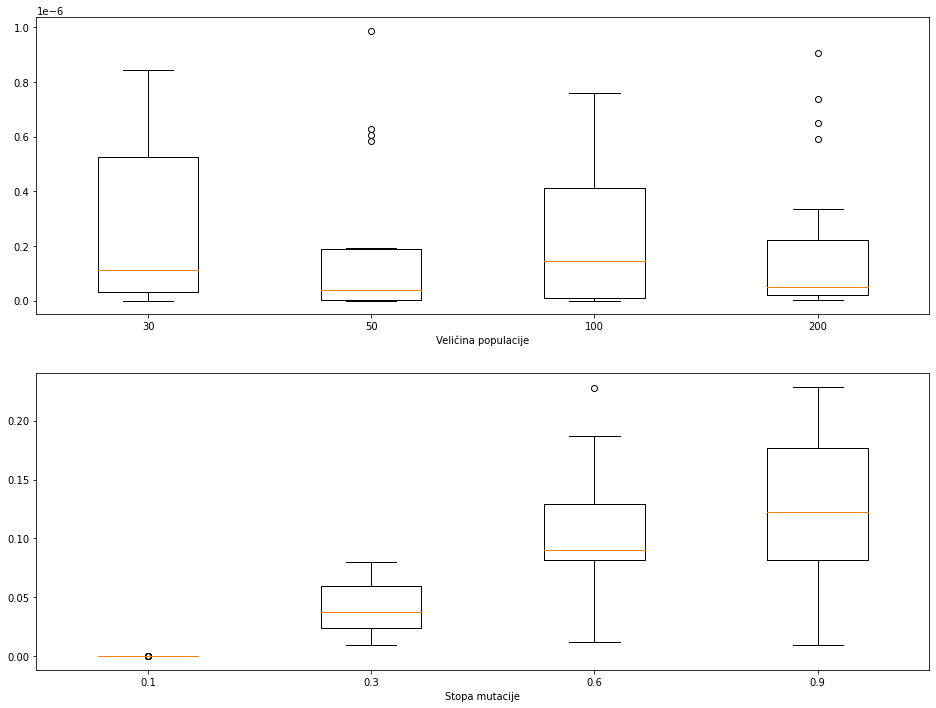

In [75]:
t4_fig, t4_ax = plt.subplots(2, 1, figsize=(16, 12))

t4_ax[0].boxplot([x[0] for x in t4_capacity_values])
t4_ax[0].set_xticklabels([str(x[1]) for x in t4_capacity_values])
t4_ax[0].set_xlabel("Veličina populacije")

t4_ax[1].boxplot([x[0] for x in t4_mutation_probability_values])
t4_ax[1].set_xticklabels([str(x[1]) for x in t4_mutation_probability_values])
t4_ax[1].set_xlabel("Stopa mutacije")

t4_fig.show();

### Zadatak 5

Ako ste implementirali turnirsku selekciju, probajte nad nekom težom funkcijom ($f_6$ ili $f_7$) izvesti algoritam koristeći različite veličine turnira. Pomaže li veći turnir algoritmu da pronađe bolja rješenja? Ako ste implementirali selekciju *roulette wheel*,isprobajte više vrijednosti omjera odabira najbolje i najlošije jedinke (skaliranje funkcije cilja) te komentirajte dobivene rezultate (također možete isprobati generacijsku i eliminacijsku varijantu).

In [76]:
t5_tournament_sizes = (3, 5, 7, 8)

In [77]:
t5_interval = (-50, 150)

In [78]:
t5_n_decimals = 6
t5_dim = get_binary_dim_for_interval_and_decimals(
    interval=t5_interval, n_decimals=t5_n_decimals
)
display(
    Markdown(
        f"Za interval $[{t5_interval[0]}, {t5_interval[1]}]$ "
        f"trebat ćemo ${t5_dim}$ binarnih znamenaka da bi "
        f"imali preciznost na ${t5_n_decimals}$ decimale."
    )
)

Za interval $[-50, 150]$ trebat ćemo $28$ binarnih znamenaka da bi imali preciznost na $6$ decimale.

In [79]:
t5_be = BinaryEncoder(
    dim=t5_dim, interval=t5_interval
)
t5_bd = BinaryDecoder(
    dim=t5_dim, interval=t5_interval
)

In [80]:
t5_f6 = copy.deepcopy(f6)

In [81]:
t5_f6_binary = Function(lambda x: -t5_f6(t5_bd(x)))

In [82]:
t5_max_iterations = 10000
t5_max_retries = 20
t5_specimen_length = 3
t5_capacity = 20
t5_elitism = 1
t5_epsilon = 1e-6

In [83]:
t5_mp_schedule = lambda x: 0.05 * (np.sin(x/1000) + 1)

In [84]:
t5_folder_name = "data/task-05"

In [85]:
t5_et_binary = EvolutionaryTournament(
    selection=TournamentSelection(),
    crossover=ANDCrossover(),
    mutation=StochasticCorruptionMutation()
)

In [86]:
t5_result_dict = dict()

for t5_tournament_size in t5_tournament_sizes:
    _name = f"tournament-size-{t5_tournament_size}"
    _file_name = f"{_name}.pickle"
    _file_path = os.path.join(t5_folder_name, _file_name)
    
    if not os.path.exists(_file_path):
        t5_results = simple_ga(
            wellness_function=t5_f6_binary,
            specimen_length=t5_specimen_length,
            interval=t5_interval,
            evolutionary_tournament=t5_et_binary,
            max_retries=t5_max_retries,
            max_iterations=t5_max_iterations,
            population_capacity=t5_capacity,
            elitism=t5_elitism,
            epsilon=t5_epsilon,
            stop_prematurely=False,
            mutation_scheduler=t5_mp_schedule,
            encoding_function=t5_be,
            decoding_function=t5_bd,
        )
            
        os.makedirs(t5_folder_name, exist_ok=True)

        with open(_file_path, mode="wb+") as file:
            _results = np.array([specimen.wellness for specimen in t5_results])
                                 
            pickle.dump(
                {
                    "tournament_size": t5_tournament_size,
                    "results": _results
                },
                file
            )

        print()
                
    with open(_file_path, mode="rb") as file:
        t5_result_dict[_name] = pickle.load(file)

In [87]:
t5_tournament_size_values = [
    ([-y for y in x["results"]], x["tournament_size"])
    for x in t5_result_dict.values()
]

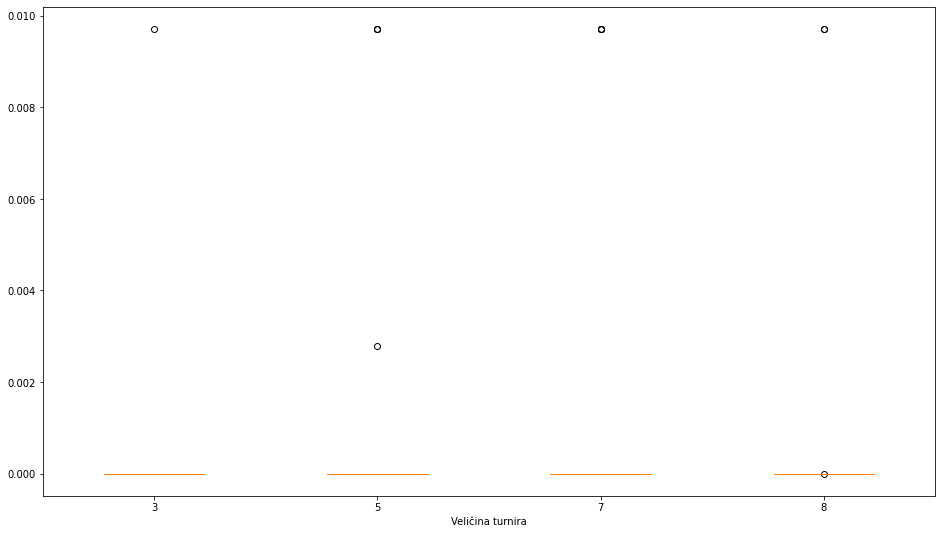

In [88]:
t5_fig, t5_ax = plt.subplots(1, 1, figsize=(16, 9))

t5_ax.boxplot([x[0] for x in t5_tournament_size_values])
t5_ax.set_xticklabels([str(x[1]) for x in t5_tournament_size_values])
t5_ax.set_xlabel("Veličina turnira")

t5_fig.show();

**Komentar**:

Po boxplotovima se ne vidi neka prevelika pravilnost. Raspršenje u pravilu dominira nad aritmetičkom sredinom, pa odabir veličine turnira s našim postavkama ne mijenja stvari previše. Ovo je indikator da nam je mutacija čak i pri velikom selekcijskom pritisku efektivna u razrješavanju lokalnih minimuma.